In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(464)

Current device: cuda
GPU Name: NVIDIA GeForce RTX 2070 SUPER
Total GPU Memory: 8.0 GB


In [7]:
class CifarDataset(Dataset):
        def __init__(self, root_dir):
            self.root_dir = root_dir
            self.images = self.read_dataset()
        
        def __len__(self):
            return len(self.images)
        
        def __getitem__(self, data_id):
            image = self.images[data_id]
        
            return image
            
        def read_dataset(self):
            images = []
        
        
            for label in os.listdir(self.root_dir):
                label_path = os.path.join(self.root_dir, label)
                if os.path.isdir(label_path):
                    for img_file in os.listdir(label_path):
                        img_path = os.path.join(label_path, img_file)
                        if img_path.endswith(('.png', '.jpg', '.jpeg')):
                            img = Image.open(img_path)
                            img = img.resize((32, 32), Image.BICUBIC) # gives  DeprecationWarning however, still works
                            img = transforms.ToTensor()(img)
                            img = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(img)
                            images.append(img)
        
            return images

In [8]:
train_dataset = CifarDataset(root_dir='/Users/tolga/Desktop/CS464/cifar100/train') # gives  DeprecationWarning however, still works
test_dataset = CifarDataset(root_dir='/Users/tolga/Desktop/CS464/cifar100/test')


C:\Users\Tolga\AppData\Local\Temp\ipykernel_18648\2428467606.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((32, 32), Image.BICUBIC) # gives  DeprecationWarning however, still works


In [8]:
# Create train and test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

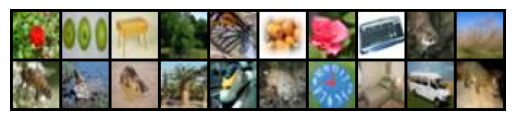

In [9]:
images = next(iter(train_dataloader)) # Taking one batch from the dataloader
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [10]:
class CifarAutoencoder(nn.Module):
    def __init__(self):
        super(CifarAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.batch_norm1 = nn.BatchNorm2d(16) # Batch normalization after conv1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.batch_norm2 = nn.BatchNorm2d(32) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.batch_norm3 = nn.BatchNorm2d(64) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.deconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2,padding=0, output_padding=0)
        self.batch_norm4 = nn.BatchNorm2d(32)
        self.deconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2,padding=0, output_padding=0)
        self.batch_norm5 = nn.BatchNorm2d(16)
        self.deconv3 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=6, stride=2,padding=0, output_padding=0)


    def forward(self, x):
        x = self.pool1(self.batch_norm1(nn.functional.leaky_relu(self.conv1(x),  negative_slope=0.2)))
        x = self.pool2(self.batch_norm2(nn.functional.leaky_relu(self.conv2(x),  negative_slope=0.2)))
        x = self.pool3(self.batch_norm3(nn.functional.leaky_relu(self.conv3(x),  negative_slope=0.2)))
        
        
        x = nn.functional.leaky_relu(self.batch_norm4(self.deconv1(x)), negative_slope=0.2)
        x = nn.functional.leaky_relu(self.batch_norm5(self.deconv2(x)), negative_slope=0.2)
        x = self.deconv3(x)
        x = torch.tanh(x)
        return x
        

model = CifarAutoencoder()
model.to(device)



CifarAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
  (batch_norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
  (batch_n

In [11]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    criterion= loss_func
    optimizer= optimizer
    num_epochs = num_epochs
    plot_error=[]
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            masked= data.clone().to(device)
            masked[:,:,:,16:] = -1
            inputs, labels = masked.to(device) , data.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 782 == 781:  # last element of the mini batches
                print(f"Epoch [{epoch + 1}/{num_epochs}], "
                      f"Loss: {running_loss / 782:.4f}")
                plot_error.append(running_loss / 782)
                running_loss = 0.0

    print('Finished Training')
    return plot_error #to be used in the plot

In [12]:
def evaluate_model(model, test_dataloader):
    model.eval()
    error=[]
    criterion=nn.MSELoss()
    with torch.no_grad():
        for data in test_dataloader:
            masked= data.clone()
            masked[:,:,:,16:] = -1
            inputs, labels = masked.to(device) , data.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            error.append(loss)
    return float((sum(error) / len(error)).item())

In [ ]:
%%time
num_epochs=50
error=train_model(model, train_dataloader, optim.Adam(model.parameters(), lr=0.0002),nn.MSELoss(), num_epochs)

Epoch [1/50], Loss: 0.1323
Epoch [2/50], Loss: 0.0985
Epoch [3/50], Loss: 0.0930
Epoch [4/50], Loss: 0.0890
Epoch [5/50], Loss: 0.0866
Epoch [6/50], Loss: 0.0851
Epoch [7/50], Loss: 0.0839
Epoch [8/50], Loss: 0.0827
Epoch [9/50], Loss: 0.0819
Epoch [10/50], Loss: 0.0813
Epoch [11/50], Loss: 0.0807
Epoch [12/50], Loss: 0.0800
Epoch [13/50], Loss: 0.0795
Epoch [14/50], Loss: 0.0792
Epoch [15/50], Loss: 0.0787
Epoch [16/50], Loss: 0.0783
Epoch [17/50], Loss: 0.0780
Epoch [18/50], Loss: 0.0777
Epoch [19/50], Loss: 0.0772
Epoch [20/50], Loss: 0.0769
Epoch [21/50], Loss: 0.0766
Epoch [22/50], Loss: 0.0764
Epoch [23/50], Loss: 0.0761
Epoch [24/50], Loss: 0.0758
Epoch [25/50], Loss: 0.0755
Epoch [26/50], Loss: 0.0752
Epoch [27/50], Loss: 0.0751
Epoch [28/50], Loss: 0.0749
Epoch [29/50], Loss: 0.0747
Epoch [30/50], Loss: 0.0745
Epoch [31/50], Loss: 0.0743
Epoch [32/50], Loss: 0.0741
Epoch [33/50], Loss: 0.0740
Epoch [34/50], Loss: 0.0739
Epoch [35/50], Loss: 0.0735
Epoch [36/50], Loss: 0.0735
E

In [ ]:
plt.plot(range(1,num_epochs+1),error)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs. Loss')

In [ ]:
print(evaluate_model(model.to(device), test_dataloader))

In [ ]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

In [ ]:
visualize_inpainting(model,train_dataset)

In [2]:
notebook_directory = os.getcwd()

# Print the directory path
print("Notebook Directory:", notebook_directory)

Notebook Directory: C:\Users\Tolga\Desktop\CS464\CS
